# Transfer learning

Как обучить нейросеть на своих данных, когда их мало?

Для такой типовой задачи, как классификация изображений, можно воспользоваться одной из существующих архитектур (AlexNet, VGG, Inception, ResNet и т.д.) и просто обучить нейросеть на своих данных. Реализации таких сетей с помощью различных фреймворков уже существуют, так что на данном этапе можно использовать одну из них как черный ящик, не вникая в принцип её работы. Например, в PyTorch есть множество уже реализованных известных архитектур: [torchvision.models](https://pytorch.org/vision/stable/models.html).

Однако глубокие нейронные сети требуют больших объемов данных для успешного обучения. И, зачастую, в нашей частной задаче недостаточно данных для того, чтобы хорошо обучить нейросеть с нуля. **Transfer learning** решает эту проблему. По сути мы пытаемся использовать опыт, полученный нейронной сетью при обучении на некоторой задаче $T_1$, чтобы решать схожую задачу $T_2$.

К примеру, transfer learning можно использовать при решении задачи классификации изображений на небольшом наборе данных. Как уже ранее обсуждалось, при обработке изображений свёрточные нейронные сети в первых слоях "реагируют" на некие простые пространственные шаблоны (к примеру, углы), после чего комбинируют их в сложные осмысленные формы (к примеру, глаза или носы). Вся эта информация извлекается из изображения, на её основе создаются сложные представления данных, которые в результате классифицируются линейной моделью.

Идея заключается в том, что если изначально обучить модель на некоторой сложной и довольно общей задаче, то можно надеяться, что она (как минимум часть ее слоев), в общем случае, будет извлекать важную информацию из изображений, и полученные представления можно будет успешно использовать для классификации линейной моделью.

Таким образом, берем часть модели, которая, по нашему представлению, отвечает за выделение хороших признаков (часто — все слои, кроме последнего) — feature extractor. Присоединяем к этой части один или несколько дополнительных слоёв для решения уже новой задачи. И учим только эти слои. Cлои feature extractor не учим — они "заморожены".

<img src ="https://edunet.kea.su/repo/EduNet-content/L11/out/transfer_learning_change_classes_scheme.png" width="700">

Понятно, что не все фильтры модели будут использованы максимально эффективно — к примеру, если мы работаем с изображениями, связанными с едой, возможно, не все фильтры на скрытых слоях предобученной на ImageNet модели окажутся полезны для нашей задачи. Почему бы не попробовать **не только обучить новый классификатор, но и дообучить некоторые промежуточные слои**? При использовании этого подхода мы при обучении дополнительно "настраиваем" и промежуточные слои, называется он **fine-tuning**.

При fine-tuning используют меньший learning rate, чем при обучении нейросети с нуля: мы знаем, что по крайней мере часть весов нейросети выполняет свою задачу хорошо, и не хотим испортить это быстрыми изменениями.

Кроме этого, можно делать комбинации этих методов: сначала учить только последние добавленные нами слои сети, затем учить еще и самые близкие к ним, и после этого учить уже все веса нейросети вместе. То есть мы можем определить свою **стратегию fine-tuning**.

Иногда fine-tuning считается синонимом Transfer learning, в этом случае часть от предтренированной сети называют **backbone** ("позвоночник"), а добавленную часть — **head** ("голова").



## Порядок действий при transfer learning

Последовательно рассмотрим шаги, необходимые для реализации подхода transfer learning.

**Шаг 1. Получение предварительно обученной модели**

Первым шагом является выбор предварительно обученной модели, которую мы хотели бы использовать в качестве основы для обучения. Основным предположением является то, что признаки, которые умеет выделять из данных предобученная модель, хорошо подойдут для решения нашей частной задачи. Поэтому эффект от Transfer learning будет тем лучше, чем более схожими будут **домены** в нашей задаче и в задаче, на которой предварительно обучалась модель.

Для задач обработки изображений очень часто используются модели, предобученные на ImageNet. Такой подход распространен, однако, если ваша задача связана, например, с обработкой снимков клеток под микроскопом, то модель, предобученная на более близком домене (тоже на снимках клеток, пусть и совсем других), может быть лучшим начальным решением.

<img src ="https://edunet.kea.su/repo/EduNet-content/L11/out/transfer_learning_step_1.png" width="600">

**Шаг 2. Заморозка предобученных слоев**

Мы предполагаем, что первые слои модели уже хорошо натренированы выделять какие-то абстрактные признаки из данных. Поэтому мы не хотим "сломать" их, особенно если начнем на этих признаках обучать новые слои, которые инициализируются случайно: на первых шагах обучения ошибка будет большой и мы можем сильно изменить "хорошие" предобученные веса.

Поэтому требуется "заморозить" предобученные веса. На практике заморозка означает **отключение подсчета градиентов**. Таким образом при последующем обучении параметры с отключенным подсчетом градиентов не будут обновляться.



<img src ="https://edunet.kea.su/repo/EduNet-content/L11/out/transfer_learning_step_2.png" width="600">

**Шаг 3. Добавление новых обучаемых слоев**

В отличие от начальных слоев, которые выделяют достаточно общие признаки из данных, более близкие к выходу слои предобученной модели сильно специфичны конкретно под ту задачу, на которую она обучалась. Для моделей, предобученных на ImageNet, последний слой заточен конкретно под предсказание 1000 классов из этого набора данных. Кроме этого, последние слои могут не подходить под новую задачу архитектурно: в новой задаче может быть меньше классов, 10 вместо 1000. Поэтому, требуется **заменить последние один или несколько слоев** предобученной модели на новые, подходящие под нашу задачу. При этом, естественно, веса в этих слоях будут инициализированы случайно. Именно эти слои мы и будем обучать на следующем шаге.




<img src ="https://edunet.kea.su/repo/EduNet-content/L11/out/transfer_learning_step_3.png" width="600">

**Шаг 4. Обучение новых слоев**

Все, что нам теперь нужно — обучить новые слои на наших данных. При этом замороженные слои используются лишь как **экстрактор высокоуровневых признаков**.
Обучение такой модели существенно ничем не отличается от обучения любой другой модели: используется обучающая и валидационная выборка, контролируется изменение функции потерь и функционала качества.

<img src ="https://edunet.kea.su/repo/EduNet-content/L11/out/transfer_learning_step_4.png" width="600">

**Шаг 5. Тонкая настройка модели (fine-tuning)**

После того, как мы обучили новые слои модели, и они уже как-то решают задачу, мы можем разморозить ранее замороженные веса, чтобы **тонко настроить** их под нашу задачу, в надежде, что это позволит еще немного повысить качество.

Нужно быть осторожным на этом этапе, использовать learning rate на порядок или два меньший, чем при основном обучении, и одновременно с этим следить за возникновением переобучения. Переобучение при fine-tuning может возникать из-за того, что мы резко увеличиваем количество настраиваемых параметров модели, но при этом наш датасет остается небольшим, и мощная модель может начать заучивать обучающие данные.

<img src ="https://edunet.kea.su/repo/EduNet-content/L11/out/transfer_learning_step_5.png" width="600">

## Практический пример transfer learning

Давайте рассмотрим пример практической реализации такого подхода ([код переработан из этой статьи](https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/)).

Загрузим датасет EuroSAT и удалим из него 90% файлов. EuroSAT — датасет для классификации спутниковых снимков по типам местности: лес, река, жилая застройка и т. п.

In [1]:
import random
import torch
import os
from random import sample
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [2]:
import os
from random import sample

!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/EuroSAT.zip # http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip -qn EuroSAT.zip

os.chdir("/content")
path = "/content/2750/"

for folder in os.listdir(path):
  files = os.listdir(path + folder)
  for file in sample(files, int(len(files) * 0.9)):
    os.remove(path + folder + "/" + file)

Определим аугментации. Для примера будем использовать родные аугментации из библиотеки Torchvision

In [37]:
from torchvision import transforms

# Applying Transforms to the Data
img_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()
        ]
    ),
    # No augmentations on valid data!
    "valid": transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor()
        ]
    ),
    # No augmentations on test data!
    "test": transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor()
        ]
    ),
}

Создадим `datasets`

In [38]:
from torchvision import datasets
from copy import deepcopy

path = "/content/2750/"

dataset = datasets.ImageFolder(root=path)
# split to train/valid/test
train_set, valid_set, test_set = torch.utils.data.random_split(
    dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.1), int(len(dataset) * 0.1)]
)

train_set.dataset = deepcopy(train_set.dataset)
valid_set.dataset = deepcopy(valid_set.dataset)
test_set.dataset = deepcopy(test_set.dataset)

# define augmentations
train_set.dataset.transform = img_transforms["train"]
valid_set.dataset.transform = img_transforms["valid"]
test_set.dataset.transform = img_transforms["test"]

print(f"Train size: {len(train_set)}")
print(f"Valid size: {len(valid_set)}")
print(f"Test size: {len(test_set)}")

Train size: 2160
Valid size: 270
Test size: 270


In [39]:
from torch.utils.data import DataLoader

# Batch size
batch_size = 64

# Number of classes
num_classes = 10

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {num: k for k, num in dataset.class_to_idx.items()}

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size, valid_data_size = len(train_set), len(valid_set)

# Create iterators for the Data loaded using DataLoader module
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
print("indexes to class: ")
print(idx_to_class)

indexes to class: 
{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


В наборе данных не так уж и много изображений. При обучении с нуля нейросеть скорее всего не достигнет высокой точности.

### Обучение готовой архитектуры "с нуля"

Загрузим MobileNet v2 без весов и попробуем обучить "с нуля", то есть с весов, инициализированных случайно.

In [40]:
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=None).to(device)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Последний слой MobileNet дает на выходе предсказания для 1000 классов, а в нашем датасете классов всего 10. Поэтому мы должны изменить выход сети так, чтобы он выдавал 10 предсказаний. Поэтому мы заменяем последний слой модели MobileNet слоем с `num_classes` нейронами, равным числу классов в нашем датасете.

То есть мы "сказали" нашей модели распознавать не 1000, а только `num_classes` классов.

In [41]:
# Change the final layer of MobileNet Model for Transfer Learning
import torch.nn as nn

# change out classes, from 1000 to 10
model.classifier[1] = nn.Linear(1280, out_features=10).to(device)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)


Затем мы определяем функцию потерь и оптимизатор, которые будут использоваться для обучения.

In [42]:
import torch.optim as optim

# Define Optimizer and Loss Function

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)


Для тренировки и валидации нашей модели напишем отдельную функцию.

In [43]:
import time

def train_and_validate(model, criterion, optimizer, num_epochs=25, save_state=False):
    """
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    """

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, num_epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        train_correct = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Clean existing gradients
            outputs = model(inputs)
            # Forward pass - compute outputs on input data using the model
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the parameters

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            # Compute correct predictions
            train_correct += (torch.argmax(outputs, dim=-1) == labels).float().sum()

        # Compute the mean train accuracy
        train_accuracy = 100 * train_correct / (len(train_loader) * batch_size)

        val_correct = 0
        # Validation - No gradient tracking needed
        with torch.no_grad():
            model.eval()  # Set to evaluation mode

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                # Forward pass - compute outputs on input data using the model
                loss = criterion(outputs, labels)   # Compute loss
                valid_loss += loss.item() * inputs.size(0)
                # Compute the total loss for the batch and add it to valid_loss

                val_correct += (torch.argmax(outputs, dim=-1) == labels).float().sum()

        # Compute mean val accuracy
        val_accuracy = 100 * val_correct / (len(valid_loader) * batch_size)

        # Find average training loss and training accuracy
        avg_train_loss = train_loss / (len(train_loader) * batch_size)

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss / (len(valid_loader) * batch_size)

        history.append(
            [
                avg_train_loss,
                avg_valid_loss,
                train_accuracy.detach().cpu(),
                val_accuracy.detach().cpu(),
            ]
        )

        epoch_end = time.time()

        print(
            "Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
                epoch + 1,
                avg_train_loss,
                train_accuracy.detach().cpu(),
                avg_valid_loss,
                val_accuracy.detach().cpu(),
                epoch_end - epoch_start,
            )
        )
        # Saving state for fine_tuning (because we may overfit)
        if save_state:
            os.makedirs("check_points", exist_ok=True)
            torch.save(model.state_dict(), f"check_points/fine_tuning_{epoch + 1}.pth")

    return model, history

Теперь обучим нашу модель:

In [44]:
num_epochs = 20
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs, True)

torch.save(history, "history_fresh.pt")

Epoch: 1/20
Epoch : 001, Training: Loss: 1.8527, Accuracy: 31.8934%, 
		Validation : Loss : 2.5143, Accuracy: 6.8750%, Time: 10.1857s
Epoch: 2/20
Epoch : 002, Training: Loss: 1.3628, Accuracy: 50.5515%, 
		Validation : Loss : 3.2954, Accuracy: 9.6875%, Time: 10.5812s
Epoch: 3/20
Epoch : 003, Training: Loss: 1.2849, Accuracy: 53.9062%, 
		Validation : Loss : 1.2660, Accuracy: 43.1250%, Time: 10.8611s
Epoch: 4/20
Epoch : 004, Training: Loss: 1.1475, Accuracy: 58.0882%, 
		Validation : Loss : 1.1519, Accuracy: 47.1875%, Time: 10.2537s
Epoch: 5/20
Epoch : 005, Training: Loss: 1.1022, Accuracy: 60.1103%, 
		Validation : Loss : 1.2315, Accuracy: 48.4375%, Time: 10.5742s
Epoch: 6/20
Epoch : 006, Training: Loss: 1.0494, Accuracy: 61.9485%, 
		Validation : Loss : 0.7785, Accuracy: 56.5625%, Time: 9.8275s
Epoch: 7/20
Epoch : 007, Training: Loss: 1.0044, Accuracy: 63.7408%, 
		Validation : Loss : 0.8220, Accuracy: 57.8125%, Time: 10.3160s
Epoch: 8/20
Epoch : 008, Training: Loss: 0.9784, Accuracy:

Посмотрим на графики:

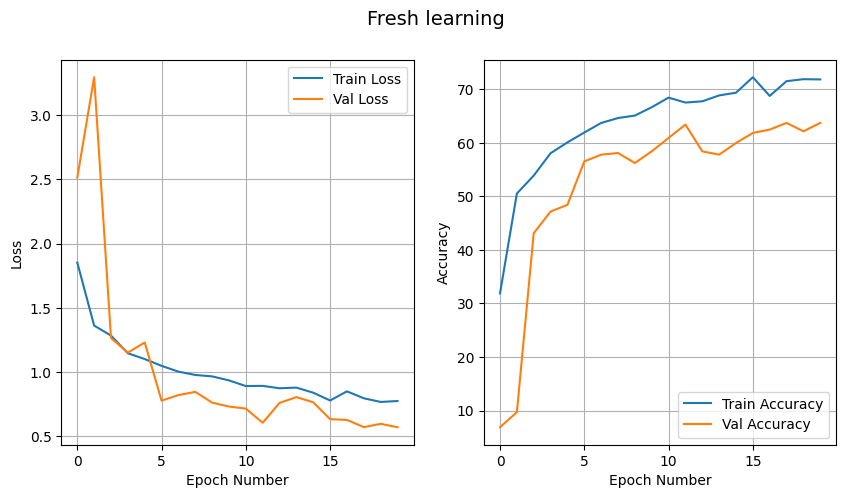

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Fresh learning", fontsize=14)

history = np.array(history)
ax[0].plot(history[:, :2])
ax[0].legend(["Train Loss", "Val Loss"])
ax[1].plot(history[:, 2:])
ax[1].legend(["Train Accuracy", "Val Accuracy"])
ax[0].set_xlabel("Epoch Number")
ax[1].set_xlabel("Epoch Number")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
plt.savefig("loss_curve.png")
ax[0].grid()
ax[1].grid()
plt.show()

Точность на валидационной выборке не превысила 66%. Посмотрим, сможем ли мы добиться большей точности при использовании предобученной модели.

### Обучение готовой архитектуры с предобученными весами

#### Обучение классификационной "головы"

Теперь давайте попробуем использовать transfer learning.

Загрузим **предобученную на ImageNet** модель MobileNet v2:

In [46]:
del model
model = models.mobilenet_v2(weights=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


В данном случае мы не дообучаем скрытые слои нашей модели, поэтому отключаем подсчёт градиентов ("**замораживаем**" параметры).

In [47]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

Нам снова нужно изменить выход сети так, чтобы он выдавал 10 классов вместо 1000.

Мы могли бы изменить количество выходов сети, просто подменив последний линейный слой, как в примере обучения с нуля:

`model.classifier[1] = nn.Linear(1280, num_classes)`

Но нужно понимать, что **мы не ограничены архитектурой готовой сети**, и можем как подменять слои, так и добавлять новые. Поэтому в целях демонстрации мы заменим выходной слой исходной сети на два слоя: первый мы добавим "подменой" модуля, а затем добавим активацию и новый выходной слой с `num_classes` выходами с помощью метода `add_module()` класса `Sequential`.

Когда мы подменяем или добавляем слои, по умолчанию подсчет градиентов на них будет включен, и таким образом мы добьемся, что **учиться будут только новые слои**, веса которых инициализируются случайно.


In [48]:
# Change the final layers of MobileNet Model for Transfer Learning

model.classifier[1] = nn.Linear(1280, 500, bias=True)  # replace last module to our custom, e.g. with 500 neurons
model.classifier.add_module("2", nn.ReLU())  # add activation ReLU
model.classifier.add_module("3", nn.Linear(500, 10, bias=True))  # add new output layer with 10  out classes

print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=500, bias=True)
  (2): ReLU()
  (3): Linear(in_features=500, out_features=10, bias=True)
)


In [49]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [50]:
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [51]:
num_epochs = 20
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs, True)

torch.save(history, "history_transfer_learning.pt")

Epoch: 1/20
Epoch : 001, Training: Loss: 1.6700, Accuracy: 49.0809%, 
		Validation : Loss : 1.1648, Accuracy: 51.8750%, Time: 7.1593s
Epoch: 2/20
Epoch : 002, Training: Loss: 1.0229, Accuracy: 67.1875%, 
		Validation : Loss : 0.7181, Accuracy: 66.2500%, Time: 6.0906s
Epoch: 3/20
Epoch : 003, Training: Loss: 0.8430, Accuracy: 72.1048%, 
		Validation : Loss : 0.6004, Accuracy: 65.3125%, Time: 6.9499s
Epoch: 4/20
Epoch : 004, Training: Loss: 0.7706, Accuracy: 73.2537%, 
		Validation : Loss : 0.5435, Accuracy: 69.6875%, Time: 5.9818s
Epoch: 5/20
Epoch : 005, Training: Loss: 0.7474, Accuracy: 73.6213%, 
		Validation : Loss : 0.4979, Accuracy: 66.8750%, Time: 7.1689s
Epoch: 6/20
Epoch : 006, Training: Loss: 0.6926, Accuracy: 76.1489%, 
		Validation : Loss : 0.4609, Accuracy: 69.3750%, Time: 5.9903s
Epoch: 7/20
Epoch : 007, Training: Loss: 0.6755, Accuracy: 76.4706%, 
		Validation : Loss : 0.4210, Accuracy: 70.3125%, Time: 7.1237s
Epoch: 8/20
Epoch : 008, Training: Loss: 0.6178, Accuracy: 79.

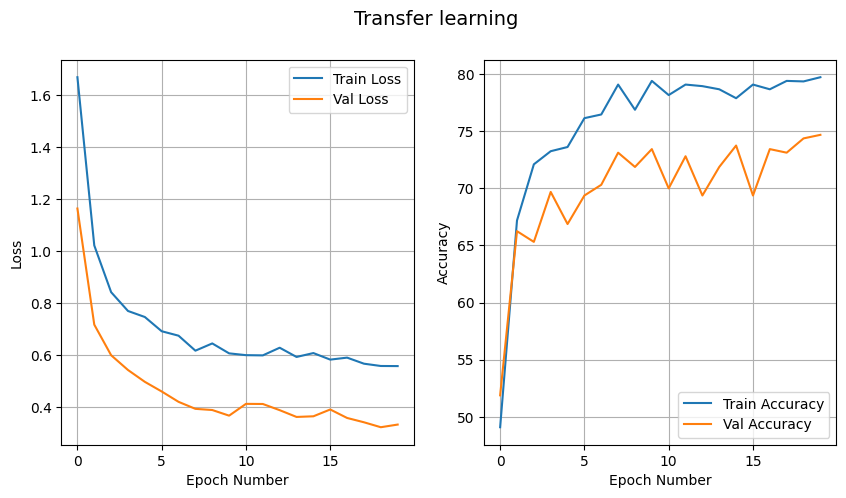

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Transfer learning", fontsize=14)

history = np.array(history)
ax[0].plot(history[:, :2])
ax[0].legend(["Train Loss", "Val Loss"])
ax[1].plot(history[:, 2:])
ax[1].legend(["Train Accuracy", "Val Accuracy"])
ax[0].set_xlabel("Epoch Number")
ax[1].set_xlabel("Epoch Number")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
plt.savefig("loss_curve.png")
ax[0].grid()
ax[1].grid()
plt.show()

Сравним между собой обучение с нуля и обучение с предобученными весами.

<ipython-input-53-346bde0b614b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history_fresh = np.array(torch.load("history_fresh.pt"))
<ipython-input-53-346bde0b614b>:5: 

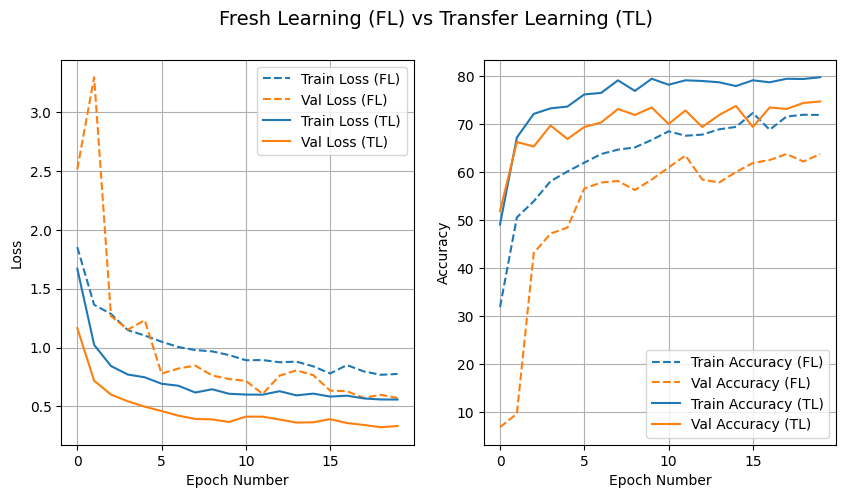

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Fresh Learning (FL) vs Transfer Learning (TL)", fontsize=14)

history_fresh = np.array(torch.load("history_fresh.pt"))
history_transfer_learning = np.array(torch.load("history_transfer_learning.pt"))

ax[0].plot(history_fresh[:, :2], linestyle="--")
ax[0].set_prop_cycle("color", ["tab:blue", "tab:orange"])
ax[0].plot(history_transfer_learning[:, :2])
ax[0].legend(["Train Loss (FL)", "Val Loss (FL)", "Train Loss (TL)", "Val Loss (TL)"])

ax[1].plot(history_fresh[:, 2:], linestyle="--")
ax[1].set_prop_cycle("color", ["tab:blue", "tab:orange"])
ax[1].plot(history_transfer_learning[:, 2:])
ax[1].legend(
    [
        "Train Accuracy (FL)",
        "Val Accuracy (FL)",
        "Train Accuracy (TL)",
        "Val Accuracy (TL)",
    ]
)
ax[0].set_xlabel("Epoch Number")
ax[1].set_xlabel("Epoch Number")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
plt.savefig("loss_curve.png")
ax[0].grid()
ax[1].grid()
plt.show()

При использовании предобученных весов процесс обучения идет более плавно и модель выдает бо́льшую точность. На валидационной выборке мы получили точность около 74%.

#### Дообучение всех слоев (Fine-tuning)

Посмотрим, сможем ли мы еще немного повысить точность путем тонкой донастройки всех весов сети.

Проведём процедуру **fine-tuning**.
В предыдущем варианте с transfer learning обучался только последний слой, добавленный вручную. Давайте проверим это, выведя те слои, в которых включён градиент.

In [54]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.conv.0.0.weight False
features.1.conv.0.1.weight False
features.1.conv.0.1.bias False
features.1.conv.1.weight False
features.1.conv.2.weight False
features.1.conv.2.bias False
features.2.conv.0.0.weight False
features.2.conv.0.1.weight False
features.2.conv.0.1.bias False
features.2.conv.1.0.weight False
features.2.conv.1.1.weight False
features.2.conv.1.1.bias False
features.2.conv.2.weight False
features.2.conv.3.weight False
features.2.conv.3.bias False
features.3.conv.0.0.weight False
features.3.conv.0.1.weight False
features.3.conv.0.1.bias False
features.3.conv.1.0.weight False
features.3.conv.1.1.weight False
features.3.conv.1.1.bias False
features.3.conv.2.weight False
features.3.conv.3.weight False
features.3.conv.3.bias False
features.4.conv.0.0.weight False
features.4.conv.0.1.weight False
features.4.conv.0.1.bias False
features.4.conv.1.0.weight False
features.4.conv.1.1.weight False
fea

Мы оставим дообученную голову нейронной сети и продолжим **обучение всей сети с уменьшением темпа обучения**.

**Разморозим** параметры. `criterion` остаётся тот же, в `optimizer` уменьшим параметр `lr` на порядок.

In [55]:
# Unfreeze model parameters
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=3e-5)

Пройдём дополнительные 20 эпох и построим графики.

In [56]:
num_epochs = 20
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs, True)

torch.save(history, "history_finetuning.pt")

Epoch: 1/20
Epoch : 001, Training: Loss: 0.5225, Accuracy: 80.8364%, 
		Validation : Loss : 0.2577, Accuracy: 77.5000%, Time: 10.8353s
Epoch: 2/20
Epoch : 002, Training: Loss: 0.4403, Accuracy: 84.4210%, 
		Validation : Loss : 0.2715, Accuracy: 76.2500%, Time: 10.3707s
Epoch: 3/20
Epoch : 003, Training: Loss: 0.3968, Accuracy: 85.2941%, 
		Validation : Loss : 0.2114, Accuracy: 79.0625%, Time: 10.3662s
Epoch: 4/20
Epoch : 004, Training: Loss: 0.3945, Accuracy: 85.5239%, 
		Validation : Loss : 0.2007, Accuracy: 80.0000%, Time: 10.1485s
Epoch: 5/20
Epoch : 005, Training: Loss: 0.3967, Accuracy: 85.1103%, 
		Validation : Loss : 0.2161, Accuracy: 77.8125%, Time: 10.3337s
Epoch: 6/20
Epoch : 006, Training: Loss: 0.3491, Accuracy: 86.4430%, 
		Validation : Loss : 0.1823, Accuracy: 79.6875%, Time: 10.2547s
Epoch: 7/20
Epoch : 007, Training: Loss: 0.3261, Accuracy: 88.1893%, 
		Validation : Loss : 0.1933, Accuracy: 80.3125%, Time: 10.0919s
Epoch: 8/20
Epoch : 008, Training: Loss: 0.3105, Accura

<ipython-input-57-b8a8d4fddf2c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history_transfer_learning = np.array(torch.load("history_transfer_learning.pt"))
<ipython-in

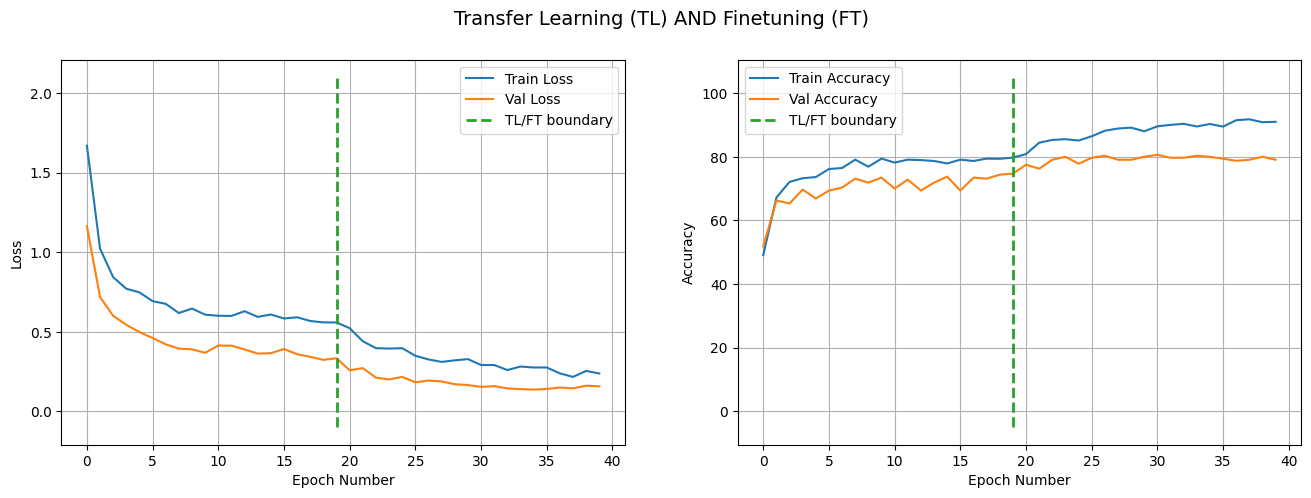

In [57]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
fig.suptitle("Transfer Learning (TL) AND Finetuning (FT)", fontsize=14)

history_transfer_learning = np.array(torch.load("history_transfer_learning.pt"))
history_finetuning = np.array(torch.load("history_finetuning.pt"))

train_val_loss = np.concatenate(
    (history_transfer_learning[:, :2], history_finetuning[:, :2]), axis=0
)
ax[0].plot(train_val_loss)
ax[0].vlines(19, -0.1, 2.1, color="tab:green", linewidth=2, linestyle="--")
ax[0].legend(["Train Loss", "Val Loss", "TL/FT boundary"])

train_val_acc = np.concatenate(
    (history_transfer_learning[:, 2:], history_finetuning[:, 2:]), axis=0
)

ax[1].plot(train_val_acc)
ax[1].vlines(19, -5, 105, color="tab:green", linewidth=2, linestyle="--")
ax[1].legend(["Train Accuracy", "Val Accuracy", "TL/FT boundary"])

ax[0].set_xlabel("Epoch Number")
ax[1].set_xlabel("Epoch Number")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
plt.savefig("loss_curve.png")
ax[0].grid()
ax[1].grid()
plt.show()

Есть ли эффект от **fine-tuning**? После дообучения ещё на 20 эпохах мы наблюдаем следующие эффекты:


*   Loss дополнительно снизился, хотя до fine-tuning он стремился к выходу на плато
*   точность на валидации превысила 80%, то есть мы получили дополнительно около 6% точности.

При fine-tuning модель может быть склонна к переобучению, так как мы обучаем сложную модель с большим числом параметров на небольшом количестве данных. Поэтому мы используем learning rate на порядок меньший, чем при обычном обучении. Для контроля переобучения следует следить за метриками и ошибкой на валидационной выборке.



Лучшее качество на валидационных данных мы получили на 38 эпохе. При fine-tuning мы сохраняли состояния нейросети на каждой эпохе. Возьмём состояние с 38 эпохи как наиболее оптимальное.

In [58]:
trained_model.load_state_dict(torch.load("check_points/fine_tuning_18.pth"))  # 38 = 20 (TL) + 18 (FT)
trained_model.eval()

<ipython-input-58-fc3011b6f322>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("check_points/fine_tuning_18.pth"))  # 38 = 20 (TL)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [63]:
def predict(model, test_img_name, device):
    """
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_img_name: Test image

    """

    transform = img_transforms["test"]
    test_img = torch.tensor(np.asarray(test_img_name))
    test_img = transforms.ToPILImage()(test_img)
    plt.imshow(test_img)

    test_img_tensor = transform(test_img).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        # Model outputs is logits
        out = model(test_img_tensor).to(device)
        probs = torch.softmax(out, dim=1).to(device)
        topk, topclass = probs.topk(3, dim=1)
        for i in range(3):
            print(
                "Predcition",
                i + 1,
                ":",
                idx_to_class[topclass.cpu().numpy()[0][i]],
                ", Score: ",
                round(topk.cpu().numpy()[0][i], 2),
            )

Посмотрим на предсказания

Should be AnnualCrop

Predcition 1 : AnnualCrop , Score:  1.0
Predcition 2 : River , Score:  0.0
Predcition 3 : PermanentCrop , Score:  0.0


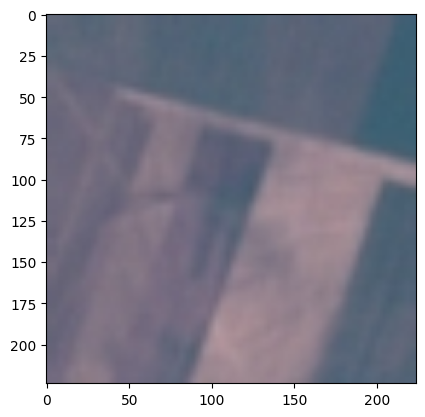

In [64]:
print("Should be %s\n" % idx_to_class[0])
predict(
    trained_model.to(device),
    test_set[np.where([x[1] == 0 for x in test_set])[0][0]][0],
    device,
)

Shoud be PermanentCrop

Predcition 1 : PermanentCrop , Score:  0.96
Predcition 2 : HerbaceousVegetation , Score:  0.04
Predcition 3 : Pasture , Score:  0.0


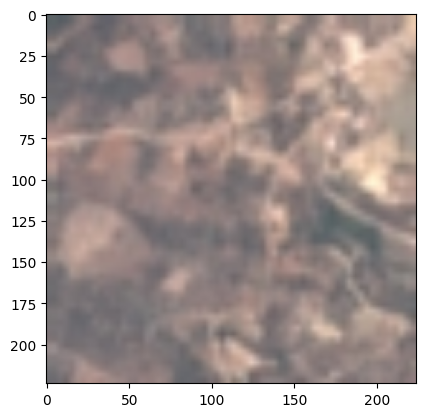

In [65]:
print("Shoud be %s\n" % idx_to_class[6])
predict(
    trained_model.to(device),
    test_set[np.where([x[1] == 6 for x in test_set])[0][0]][0],
    device,
)

Shoud be River

Predcition 1 : River , Score:  0.99
Predcition 2 : Pasture , Score:  0.01
Predcition 3 : Highway , Score:  0.01


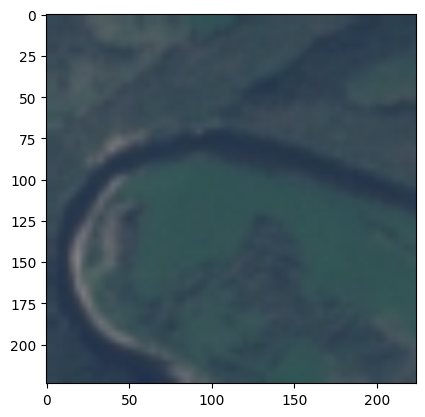

In [66]:
print("Shoud be %s\n" % idx_to_class[8])
predict(
    trained_model,
    test_set[np.where([x[1] == 8 for x in test_set])[0][0]][0],
    device,
)

* Мы увидели, как использовать предварительно обученную модель на 1000 классов ImageNet для нашей задачи на 10 классов.

* Мы сравнили качество **обучения с нуля, transfer learning и fine-tuning** и научились добиваться максимального качества с помощью этих принципов.


На практике не забывайте о характерной **опасности fine-tuning — переобучении**. Используйте **низкий learning rate** и отслеживайте Loss и показатели качества — возможно, вам будет достаточно **небольшого количества эпох**.

# Задание. Реализовать transfer learning для задачи распознавания цветов

Зачастую проще использовать уже готовую натренированную нейронную сеть, которую можно просто дообучить для решения заданной задачи, чем писать с нуля всю архитектуру.

Будем использовать [VGGNet](https://arxiv.org/pdf/1409.1556.pdf), натренированную на [ImageNet dataset](http://www.image-net.org/) для выделения основных признаков.
Напомним, что VGGNet состоить из блоков, внутри каждого расположены свёрточные и сжимающие слои, после них идут три полносвязных слоя, которые классифицируют изображения на 1000 классов:


<img src="https://datagen.tech/wp-content/uploads/2022/11/image2-1.png">

Основная идея данного задания заключается в том, чтобы сохранить все свёрточные слои, и заменить полносвязные слои на собственный классификатор.

Узнать больше про transfer learning можно на сайте [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).

---

## Шаг 1. Загрузка данных

[Загружаем данные по ссылке](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip), сохраняем их в папку под названием `flower_photos/`. **Убедитесь, что папка называется flower_photos**.

In [67]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [68]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Шаг 2. Структуризация изображений

Будем использовать PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) - метод, который позволяет удобно структурировать данные. Например, изображения для тренировки нейронной сети будут загружены в папку по классам по следующей структуре:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

В данном случае, корневая папка будет называться `flower_photos/train/` и классы ьудут называться по названию группы цветов.

In [75]:
!wget -qN https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip
!unzip -qn flower-photos.zip

In [76]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Шаг 3. Применение трансформаций к изображениям

Так как мы используем метод transfer learning, нам необзодимо привести наши данные к размерности, на которой обучалась VGG16 - `224`.

In [80]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


## Шаг 4. Использование DataLoaders и визуализация данных

In [84]:
from torch.utils.data import DataLoader

batch_size = 20
num_workers=2

# prepare data loaders
train_loader = DataLoader(train_data, batch_size, shuffle = True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size, shuffle = False, num_workers=num_workers)

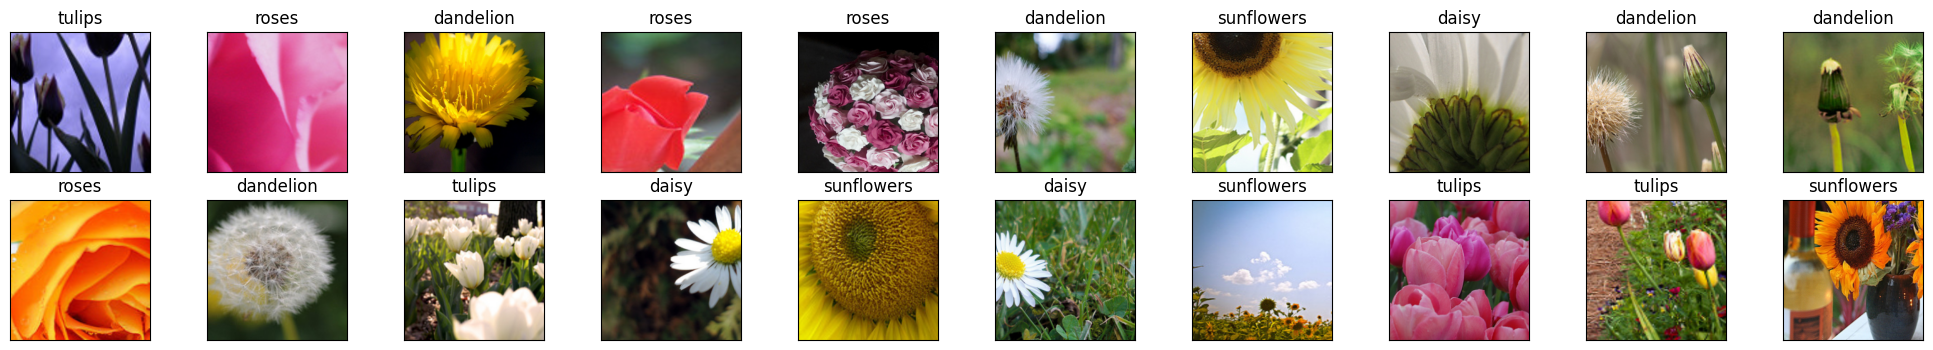

In [86]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx].item()])

---
## Шаг 5. Построение модели

Определим последовательность действий:
1. загружаем натренированную VGG16;
2. "замораживаем" все параметры, таким образом эта сеть будет ипользоваться для выделения основных признаков;
3. убираем последний слой;
4. добавляем вместо последнего слоя свой классификатор.

**Под "замораживаем" подразумевается, что параметры натренированной модели не будут меняться во время тренировки.**

In [87]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [88]:
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

4096
1000


In [89]:
# Freeze training for all "features" layers
for param in vgg16.parameters():
    param.requires_grad = False

## Шаг 6. Построение своего классификатора

Самая простая реализация - обратиться к последнему слою уже натренированной сети `vgg16.classifier[6]` и заменить его на группу "classifier".

In [90]:
import torch.nn as nn

n_inputs = 4096

# add last linear layer (n_inputs -> number flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(in_features=4096, out_features=5, bias=True)

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

5


## Шаг 7. Определим  [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) и [Optimizer](http://pytorch.org/docs/stable/optim.html)


Будем использовать кросс-энтропию в качестве функции потерть и стохастический градиентный спуск с маленьким шагом обучения. Обращаем внимание, что обновляться будут только параметры последнего слоя - добавленного класссификатора `vgg.classifier.parameters()`.

In [91]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.parameters(), lr = 0.001)

## Шаг 8. Тренировка

In [92]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()

        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.5739015102386475
Epoch 1, Batch 40 loss: 1.3921705484390259
Epoch 1, Batch 60 loss: 1.2615193724632263
Epoch 1, Batch 80 loss: 1.1774830400943757
Epoch 1, Batch 100 loss: 1.0850662857294082
Epoch 1, Batch 120 loss: 1.0723990947008133
Epoch 1, Batch 140 loss: 1.0216047137975692
Epoch 2, Batch 20 loss: 0.9365577340126038
Epoch 2, Batch 40 loss: 0.9132975786924362
Epoch 2, Batch 60 loss: 0.8712083250284195
Epoch 2, Batch 80 loss: 0.9282468229532241
Epoch 2, Batch 100 loss: 0.8226343512535095
Epoch 2, Batch 120 loss: 0.8638661116361618
Epoch 2, Batch 140 loss: 0.8771751850843430


## Шаг 9. Тестирование.

Посчитаем точность для каждого класса по отдельности.

In [94]:
# track test loss
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.814544

Test Accuracy of daisy: 77% (71/92)
Test Accuracy of dandelion: 90% (120/132)
Test Accuracy of roses: 70% (64/91)
Test Accuracy of sunflowers: 65% (66/101)
Test Accuracy of tulips: 72% (90/124)

Test Accuracy (Overall): 76% (411/540)


## Шаг 10. Визуализация части примеров.

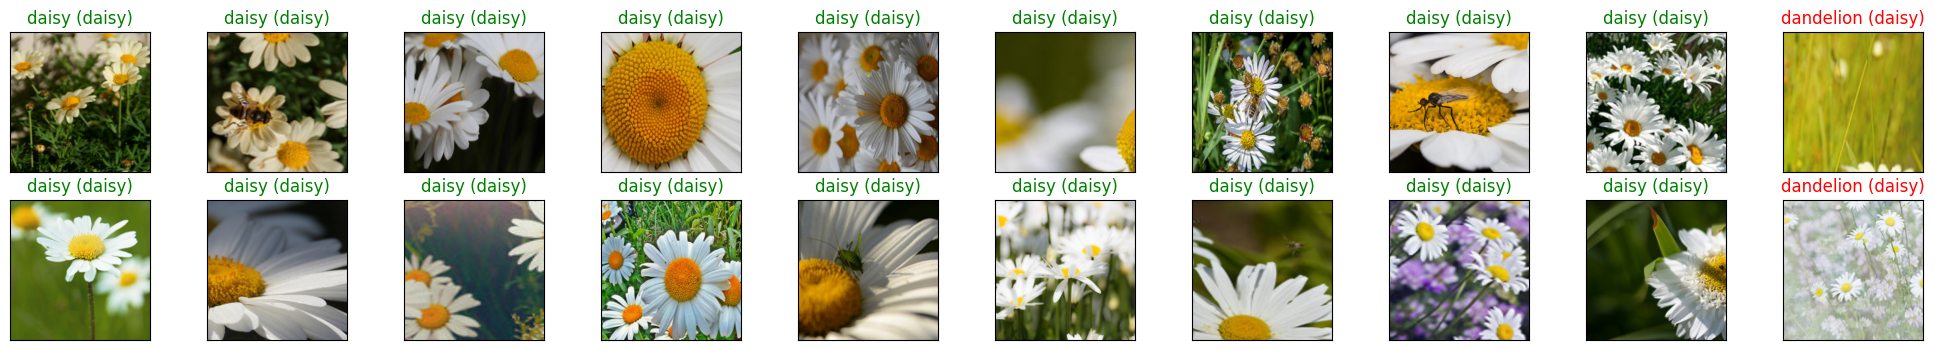

In [100]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)


# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# Задание. Реализовать Transfer Learning для задачи распознавания кошек и собак.

Решим задачу по распознаванию собак и кошек через сеть DenseNet, обученную на [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html).

[Видео про ImageNet](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

При помощи библиотеки `torchvision.models`можно загружать многие готовые обученные модели и использовать их для решения своих задач. Импортируем их как `models`.

In [101]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Набор данных ImageNet подразумевает работу с изображениями размера 224x224. Так же нам необходимо провести нормализацию данных со средним математическим ожиданием `[0.485, 0.456, 0.406]` и стандартным распределением `[0.229, 0.224, 0.225]`.

In [103]:
data_dir = 'Cat_Dog_data'

#data_dir = '/Users/katestroeva/PycharmProjects/ANN_my_education/Finansial_University/Cat_Dog_data/'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data, batch_size=64)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/katestroeva/PycharmProjects/ANN_my_education/Finansial_University/Cat_Dog_data//train'

Загрузим модель [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5) и посмотрим на её структуру:

<img src = 'https://pytorch.org/assets/images/densenet1.png'>

In [ ]:
model = models.densenet121(pretrained=True)
model

/Users/katestroeva/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/katestroeva/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Модель глобально состоит из двух частей: выделение признаков через свёрточные слои и классификатора `(classifier): Linear(in_features=1024, out_features=1000)`. Заменим этот слой на последовательность линейных слоёв, необходимых нам для решения поставленной задачи:

In [104]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

Поскольку выбранная архитектура DenseNet довольно глубокой структуры, дообучение может быть очень медленным, лучше использовать [CUDA](https://developer.nvidia.com/cuda-zone), а не GPU.

In [105]:
import time

In [106]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device)

for ii, (inputs, labels) in enumerate(trainloader):

    # Move input and label tensors to the GPU
    inputs, labels = inputs.to(device), labels.to(device)

    start = time.time()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ii==3:
        break

print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

NameError: name 'trainloader' is not defined

Запустим обучение и посмотрим на полученную точность модели:

In [ ]:
model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device)

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        logps = model(inputs)
        loss = criterion(logps, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model(inputs)
                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

KeyboardInterrupt: 